In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from scipy import signal

from sklearn.metrics import roc_curve, auc, f1_score, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import tensorflow as tf

from keras import layers, models, regularizers, Model  # Import models here
from keras.metrics import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, TimeDistributed, Input, RepeatVector
from keras.regularizers import l2



2025-01-12 18:26:10.131077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 18:26:11.513619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(f"PyTorch version: {torch.__version__}")


PyTorch version: 2.3.0+cu121


# Loading datasets 

In [3]:
background = np.load('Datasets/background.npz')['data']
bbh = np.load('Datasets/bbh_for_challenge.npy')
sglf = np.load('Datasets/sglf_for_challenge.npy')


In [4]:
background.shape, bbh.shape, sglf.shape

((100000, 2, 200), (100000, 2, 200), (100000, 2, 200))

# Kept: RNN AutoEncoder

I decided to use a mixture of RNN and Auto encoder at the end for my model.

### Preprocess and split data 

In [7]:
# Transpose the data to have shape (samples, time_steps, features)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)  # Shape: (100000, 200, 2)

# Normalize data (optional, based on your dataset characteristics)
background = background / np.max(background)
bbh = bbh / np.max(bbh)
sglf = sglf / np.max(sglf)

# Split background into training and validation sets
X_train, X_val = train_test_split(background, test_size=0.2, random_state=42)


In [8]:
# Model parameters
time_steps = 200  # Number of time steps (per segment)
features = 2      # Number of features (Hanford & Livingston streams)
latent_dim = 32   # Latent dimension for compressed representation

# Encoder
input_seq = Input(shape=(time_steps, features))
encoded = SimpleRNN(
    64, 
    activation='tanh', 
    return_sequences=False,  # Compress the entire sequence into one vector
    kernel_regularizer=l2(0.01), 
    recurrent_regularizer=l2(0.01), 
    recurrent_dropout=0.1
)(input_seq)
encoded = Dropout(0.3)(encoded)

# Latent Space
latent = Dense(latent_dim, activation='relu', kernel_regularizer=l2(0.01))(encoded)

# Decoder
decoded = RepeatVector(time_steps)(latent)  # Repeat latent vector for each time step
decoded = SimpleRNN(
    64, 
    activation='tanh', 
    return_sequences=True, 
    kernel_regularizer=l2(0.01), 
    recurrent_regularizer=l2(0.01), 
    recurrent_dropout=0.1
)(decoded)
decoded = Dropout(0.3)(decoded)
decoded = TimeDistributed(Dense(features, activation='sigmoid'))(decoded)  # Match input feature dimension

# Autoencoder Model
autoencoder = Model(inputs=input_seq, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()


2025-01-12 18:26:15.510880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:44:00.0, compute capability: 6.1


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 200, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 200, 2)         │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,706 (49.63 KB)

 Trainable params: 12,706 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = autoencoder.fit(
    X_train, X_train,  # Input and target are the same for reconstruction
    validation_data=(X_val, X_val),
    epochs=20,          # Adjust based on convergence
    batch_size=64,      # Batch size (experiment with values like 32 or 128)
    shuffle=True
)


Epoch 1/20


I0000 00:00:1736706388.591134    1614 service.cc:145] XLA service 0x7f875c00d350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736706388.591185    1614 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-01-12 18:26:29.115932: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-12 18:26:31.006139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


   3/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 35ms/step - loss: 2.4025    

I0000 00:00:1736706431.948811    1614 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 171s 93ms/step - loss: 0.7143 - val_loss: 0.0026
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 27ms/step - loss: 0.0011 - val_loss: 4.6520e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 5.4588e-05 - val_loss: 3.4826e-05
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 3.9422e-05 - val_loss: 3.2743e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 3.5117e-05 - val_loss: 3.2092e-05
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 3.3685e-05 - val_loss: 3.1852e-05
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - loss: 3.3021e-05 - val_loss: 3.1755e-05
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - loss: 3.2349e-05 - val_loss: 3.1715e-05
Epoch 9/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - loss: 3.2875e-05 - val_loss: 3.1699e-05
Epoch 10/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - loss: 3.2351e-05 - val_loss: 3.1694e-05
Epoch 11/20
1250/1250 ━━━━━━━━━━━━━━━━━━━

625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step
Average Reconstruction Loss (MSE): 0.000032
Average Reconstruction Loss (MAE): 0.004491


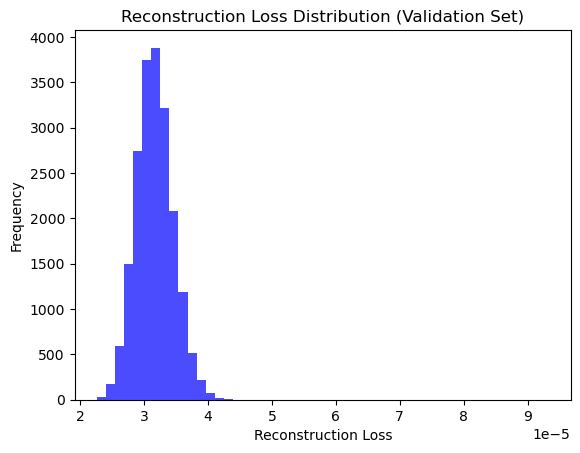

In [10]:
# Reconstruct the validation set
X_val_reconstructed = autoencoder.predict(X_val)

# Calculate reconstruction loss for each sample (per time step and feature)
reconstruction_losses = np.mean((X_val - X_val_reconstructed) ** 2, axis=(1, 2))  # MSE per sample

# Average reconstruction loss over all samples
average_mse_loss = np.mean(reconstruction_losses)
average_mae_loss = np.mean(np.mean(np.abs(X_val - X_val_reconstructed), axis=(1, 2)))

print(f"Average Reconstruction Loss (MSE): {average_mse_loss:.6f}")
print(f"Average Reconstruction Loss (MAE): {average_mae_loss:.6f}")

# Optionally, analyze the distribution of reconstruction losses
import matplotlib.pyplot as plt

plt.hist(reconstruction_losses, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Loss Distribution (Validation Set)')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.show()

In [13]:
threshold = np.percentile(reconstruction_losses, 95)  # Example: 95th percentile
anomalies = np.where(reconstruction_losses > threshold)[0]
print(f"Number of anomalies detected: {len(anomalies)}")


Number of anomalies detected: 1000


In [14]:
from scipy.stats import pearsonr

correlations = [
    pearsonr(X_val[i].flatten(), X_val_reconstructed[i].flatten())[0]
    for i in range(len(X_val))
]
avg_correlation = np.mean(correlations)
print(f"Average Correlation Coefficient: {avg_correlation:.4f}")


Average Correlation Coefficient: -0.0000


In [15]:
# Reconstruct the BBH data
BBH_reconstructed = autoencoder.predict(bbh)

# Calculate reconstruction loss for each sample in BBH dataset
bbh_reconstruction_losses = np.mean((bbh - BBH_reconstructed) ** 2, axis=(1, 2))  # MSE per sample

# Optionally, also compute MAE per sample
bbh_mae_losses = np.mean(np.abs(bbh - BBH_reconstructed), axis=(1, 2))


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step


In [17]:
# Use the 95th percentile of reconstruction losses from your validation set
threshold = np.percentile(reconstruction_losses, 95)  # Define anomaly threshold based on validation data
# Predict anomalies (1 = anomaly, 0 = normal)
bbh_predictions = (bbh_reconstruction_losses > threshold).astype(int)

# If all data in BBH is anomalous, they should all be classified as anomalies
print(f"Number of anomalies detected: {np.sum(bbh_predictions)} / {len(bbh_predictions)}")


Number of anomalies detected: 100000 / 100000


In [18]:
# Assuming ground truth labels for BBH anomalies are available (1 = anomaly)
y_bbh_true = np.ones(len(bbh))  # If all BBH data is anomalous

accuracy = accuracy_score(y_bbh_true, bbh_predictions)
precision = precision_score(y_bbh_true, bbh_predictions)
recall = recall_score(y_bbh_true, bbh_predictions)
f1 = f1_score(y_bbh_true, bbh_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


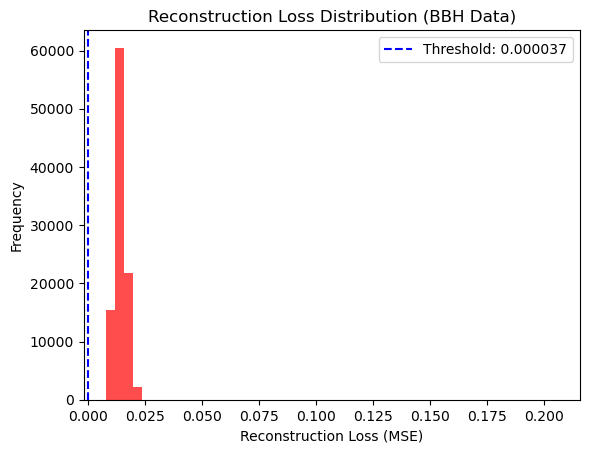

In [19]:
import matplotlib.pyplot as plt

# Plot the distribution of reconstruction losses
plt.hist(bbh_reconstruction_losses, bins=50, color='red', alpha=0.7)
plt.title('Reconstruction Loss Distribution (BBH Data)')
plt.xlabel('Reconstruction Loss (MSE)')
plt.ylabel('Frequency')
plt.axvline(threshold, color='blue', linestyle='--', label=f'Threshold: {threshold:.6f}')
plt.legend()
plt.show()


# CNN Only approach

Discrete approach from RNN. This was the first thing I tried after trying one class SVM and Isolation forest. 

In [5]:
# Transpose the datasets to match the required shape (N, 200, 2)
background = background.transpose(0, 2, 1)  # Shape: (100000, 200, 2)
bbh = bbh.transpose(0, 2, 1)                # Shape: (100000, 200, 2)
sglf = sglf.transpose(0, 2, 1)              # Shape: (100000, 200, 2)

# Combine datasets
X = np.concatenate([background, bbh, sglf], axis=0)  # Shape: (300000, 200, 2)

# Create labels: 0 for background, 1 for BBH, 2 for SGJF
y = np.concatenate([
    np.zeros(background.shape[0], dtype=int),  # Shape: (100000,)
    np.ones(bbh.shape[0], dtype=int),          # Shape: (100000,)
    np.full(sglf.shape[0], 2, dtype=int)       # Shape: (100000,)
])

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training set into training (90%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=3)





In [12]:
from tensorflow.keras import layers, models, regularizers

input_shape = (200, 2)

model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=input_shape, 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                  kernel_regularizer=regularizers.l2(0.2)),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    # Change the output layer to softmax for multi-class classification
    layers.Dense(3, activation='softmax')  # 3 classes: background, BBH, SGJF
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

# Print the model summary
model.summary()


/opt/conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 198, 16)        │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 99, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 97, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 46, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,819 (768.82 KB)

 Trainable params: 196,819 (768.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor the validation loss
    patience=5,              # Stop after 5 epochs of no improvement
    restore_best_weights=True # Restore the best weights when stopping
)

# Train the model with early stopping
history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_val, y_val_one_hot),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping] # Include the early stopping callback
)

In [ ]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=3)# Evaluate the model with one-hot encoded labels
test_loss, test_accuracy, test_mse = model.evaluate(X_test, y_test_one_hot)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test MSE: {test_mse}")


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_multiclass(model, X_test, y_test, class_labels):
    """
    Plots the ROC curve for a multi-class classification model.
    
    Parameters:
    - model: Trained Keras model.
    - X_test: Test data (features).
    - y_test: Test data (labels).
    - class_labels: List of class labels.
    """
    # Binarize the labels for multi-class ROC curve computation
    y_test_bin = label_binarize(y_test, classes=range(len(class_labels)))
    
    # Get the predicted probabilities for each class
    y_score = model.predict(X_test)
    
    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot the ROC curves
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], label=f"Class {label} (AUC = {roc_auc[i]:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve for Multi-Class Classification", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Example usage:
class_labels = ['Background', 'BBH', 'SGJF']
plot_roc_multiclass(model, X_test, y_test, class_labels)


In [25]:
y_pred_prob = model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class labels

f1_macro = f1_score(y_test, y_pred, average='macro')  # Macro F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')  # Weighted F1 score
f1_per_class = f1_score(y_test, y_pred, average=None)  # F1 score per class

print("Macro F1 Score:", f1_macro)
print("Weighted F1 Score:", f1_weighted)
print("F1 Score per Class:", f1_per_class)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step
Macro F1 Score: 0.6895172165642999
Weighted F1 Score: 0.6890974915442465
F1 Score per Class: [0.92718225 0.55113075 0.59023865]
